In [2]:
%matplotlib inline

# 592B, Class 7.1 (03/06).  The Fourier Transform in Action, Part II

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import fftpack #new

from ipywidgets import interactive
from IPython.display import Audio, display

## Review questions

- Why is the computation of the spectrum affected by the "window length" over which it is computed, and how is it affected?
- Why do you get negative frequencies when you do a Fourier Transform?
- Why and how does the choice of "window" over the waveform affect how "wide" peaks in the spectrum are?

---

## Intro

Last time we ended up with the Fourier series of $g(t)$ defined as $T \rightarrow \infty$, expressed as a double integral:

\begin{equation}
g(t) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}e^{-2\pi ift}g(t)dt e^{2\pi ift}df
\end{equation}

and then we derived $\mathcal{F}g$, where $\mathcal{F}g$ is defined as the Fourier transform of a function $g(t)$:

\begin{equation}
\mathcal{F}g = \int_{-\infty}^{\infty}e^{-2\pi ift} g(t)dt      
\end{equation}

and the inverse Fourier transform $\mathcal{F}^{-1}(t)$ of a function $\mathcal{F}g(f)$ is: 

\begin{equation}
g(t) = \int_{-\infty}^{\infty}e^{2\pi ift} \mathcal{F}gdf      
\end{equation}

Then we briefly introduced the **discrete Fourier transform (DFT)**: this is what we use when we're computing the Fourier Transform in python because we are working with *digital* signals. 





---

## The Discrete Fourier Transform

Today we're going to work on understanding the DFT a little more, because it will help us understand what's going on when we invoke `fftpack.fft` and have a deeper understanding of the answers to the review questions above. The derivation here follows Osgood Chapter 6.

Our goal is to find a discrete version of $\mathcal{F}g(f)$, the Fourier transform of a function $g(t)$. (Note: by writing $\mathcal{F}g(f)$, we mean that the function $\mathcal{F}g$, the Fourier transform of $g(t)$, is a function of frequency, $f$. We start with $g(t)$, which is a function of time $t$, but once we take the Fourier transform of $g(t)$, $\mathcal{F}g$, we have a function of frequency $f$.). 

To do this, we need to find three things:
- A discrete version of $g(t)$ that reasonably approximates $g(t)$
- A discrete version of $\mathcal{F}g(f)$ that reasonably approximates $\mathcal{F}g(f)$
- A way in which these two discrete versions are related, which approximates the relation between the continuous versions

We start by assuming that $g(t)$ is:
- *time-limited*, meaning that $g(t)$ is zero outside of $0\leq t \leq L$, where $L$ is the length of the signal (in time)
- *band-limited*, meaning that $\mathcal{F}g(f)$ vanishes outside of $0 \lt f \lt 2B$, where $B$ is the *bandwith* of the signal.


By the Sampling Theorem, if we sample $g(t)$ at the Nyquist rate of $2B$ samples/second, we can reconstruct $g(t)$ perfectly. This sampled version of $g(t)$, call it $g_{discrete}(t)$, is just a list of $N$ sampled values:

$$ g(t_0), g(t_1), \ldots, g(t_{N-1}) $$,

where $N=2BL$ and the timepoints are evenly spaced apart by $\frac{1}{2B}$.

***In-class exercise: Why is $N=2BL$ and why does $\Delta t_n = \frac{1}{2B}$?***

---


### The Dirac comb

We can re-express $g_{discrete}(t)$ using the Dirac comb $III(t)$, defined as:

$$III(t) = \displaystyle\sum_{n=0}^{N-1} \delta(t-t_n) $$

All this is is a "train" of pulses, a comb of "lollipops" with amplitude 1, where the pulses occur exactly at the sampled points $t_0, t_1, \ldots, t_{N-1}$.

Here's an image of a Dirac comb from Wikipedia. In our case, $T = 1/2B$.

<img alt = "Dirac comb plot" src="https://upload.wikimedia.org/wikipedia/commons/4/49/Dirac_comb.svg" width="300"  />


And here's an example of [one way to define a Dirac comb function](https://scipython.com/book/chapter-6-numpy/examples/a-comb-function/), from [scipython.com](https://scipython.com).


In [4]:
N, n = 101, 5
def f(i):
    return (i % n == 0) * 1

comb = np.fromfunction(f, (N,), dtype=int)
print(comb)


[1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]


***In-class discussion: Does the Dirac comb form an orthogonal basis set?***

---

Using $III(t)$, we can now express $g_{discrete}(t)$ as:

$$g_{discrete}(t) = g(t) \displaystyle\sum_{n=0}^{N-1} \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t) \delta(t-t_n) $$

And the Fourier transform of $g_{discrete}(t)$ is:

\begin{equation}
\mathcal{F}g_{discrete}(f) = \displaystyle\sum_{n=0}^{N-1} = \mathcal{F}g(t_n) \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi ift_n}      
\end{equation}

This gives us the continuous Fourier transform of the sampled version of $g(t)$.

Now let's think about $g(t)$ in the frequency domain. Remember by assumption that $g(t)$ is time-limited so $g(t)$ is zero outside of $0\leq t \leq L$, where $L$ is the length of the signal (in time). So we can apply the Sampling Theorem to reconstruct $\mathcal{F}g(f)$ in the frequency domain. The sampling rate we need (the Nyquist rate) for perfect reconstruction is $L$ samples/Hz and the spacing between sampling points is $1/L$.

Since $\mathcal{F}g(f)$ is band-limited by assumption and  vanishes outside of $0 \lt f \lt 2B$, we sample $\mathcal{F}g(f)$ over $0 \lt f \lt 2B$, with points $1/L$ Hz apart. 

---

***In-class exercise: Why is the sampling rate $L$ samples/Hz and why is the interval between sampling points $1/L$ Hz? What is the total number of sampling points, $N$***

---

This sampled version of $\mathcal{F}g(f)$, call it $\mathcal{F}g_{discrete}(f)$, is just a list of $N$ sampled values:

$$ f_0=0,\, f_1 = \frac{1}{L},\, \ldots, f_{N-1} = \frac{N-1}{L} $$,

And if we want the discrete version of $g_{discrete}(t)$, then we want to take $[\mathcal{F}(g_{discrete})](f)$, call this $F(f)$ for short.

Taking our definition of the Fourier transform of $g_{discrete}(t)$,

$$\mathcal{F}g(t_n) \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi ift_n}$$

this will give us the list:

$$ F(f_0) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_0t_n}, \ldots, F(f_{N-1})=\displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_{N-1}t_n}  $$

And so now we have a way to go from $g_{discrete}(t)$ to $\mathcal{F}g_{discrete}(f)$:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_mt_n} $$

Recalling that $t_n = \frac{n}{2B}$ and $f_m = \frac{m}{L}$ and $N=2BL$, we can re-write this as:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi inm/N} $$

***In-class exercise: derive our final expression of $F(f_m)$.***

---

At this point, let's come back to one of our starting questions and discuss. You should have more insight on this now! What is the "grid" spacing in the time-domain? The frequency domain? How are they related? 

> Why is the computation of the spectrum affected by the "window length" over which it is computed, and how is it affected?

---

## Positive and negative frequencies (Osgood 2010, p. 260)

Given our discrete Fourier transform $[\mathcal{F}(g_{discrete})](f)$, call this $F(f)$:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi inm/N} $$

it turns out that the spectrum *splits* at $N/2$. See Osgood (2010) for the derivation, but due to some periodicity relations:

$$ F[\frac{N}{2} + 1] = \overline{F[\frac{N}{2} - 1]}$$ 
$$ F[\frac{N}{2} + 2] = \overline{F[\frac{N}{2} - 2]}$$ 
$$ \vdots$$

***In-class exercise: What is F[0]? What do the periodicity relations mean geometrically?***

So because of this, the convention is to say, for a spectrum indexed from 0 to $N-1$:
- The frequencies from $m=1$ to $m= N/2-1$ are the "positive" frequencies
- The frequencies from $m=N/2+1$ to $m= N-1$ are the "negative" frequencies

For a real signal, all the information you need is in the positive frequencies and the first component $F[0]$.



## Spectral leakage

Do the exercises I found [here](https://www.gaussianwaves.com/2011/01/fft-and-spectral-leakage-2/). Note that the code is in Matlab; you'll need to port to Python and modify as necessary.

---



## (Stuff below this section: For reference only: review) The Fourier Transform in action: a first look

Remember this function?

$$y(t) = \cos \left(\frac{9\pi}{2}t\right ) $$

We worked with it when we were studying aliasing. Let's sample it at 20 Hz, for a duration of 20 seconds.

Text(0.5,1,'A familiar signal')

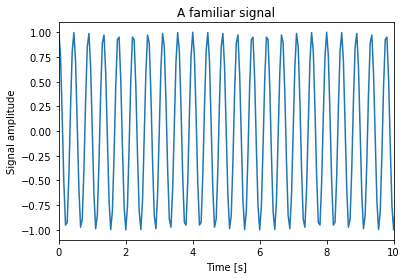

In [24]:
fs = 20 # Sampling rate of 20 Hz
t_start = 0; t_stop = 20
ns = int((t_stop - t_start) * fs)
#t = np.linspace(t_start,t_stop,ns)
t = np.linspace(t_start,t_stop,ns, endpoint=False)
x = np.cos(9/2*np.pi*t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude')
plt.xlim(0,10)
plt.title("A familiar signal")

Now let's take the Fourier Transform of the signal!

Text(0,0.5,'Fourier transform of signal')

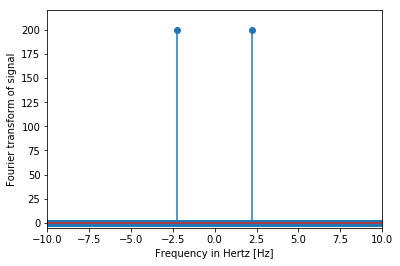

In [25]:
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * fs

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Magnitude')
ax.set_xlim(-fs/2, fs/2)
#ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-5, 220)
ax.set_ylabel('Fourier transform of signal')

We end up with non-zero values at only -2.25 and 2.25 Hz. At the moment, let's not worry about why we also get negative frequencies. 

---
***Discussion: why set the x-axis limits as [-fs/2,fs/2]?***

***Discussion: does it make sense that we're getting a peak at 2.25 Hz?***

---

***In-class exercise: what happens to the computed spectrum if you delete `endpoint=False` in the np.linspace command? Why? ***

---

***In-class exercise: repeat what we did above for the signal sampled at 1 Hz. What happens and why?***

---

### Again, a bit more slowly...

Let's walk through this step-by-step. Now let's define a complex wave with two components.

In [31]:
fs = 100
t_stop = 10
t = np.linspace(0,t_stop, t_stop*fs, endpoint=False)
f1 = 5; f2= 2
x = 0.1 * np.sin(2 * np.pi * f1 * t) + 1* np.sin(2 * np.pi * f2 * t) + 50

Let's take the Fourier Transform and inspect the values we get.

[  5.00000000e+04 +0.00000000e+00j   4.60893380e-15 -2.36665775e-14j
   1.51412688e-15 -1.59305336e-14j  -3.81791324e-14 -7.69581846e-15j
  -1.74958339e-14 +3.47472889e-14j]
1000


/Users/oxbow/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Container object of 3 artists>

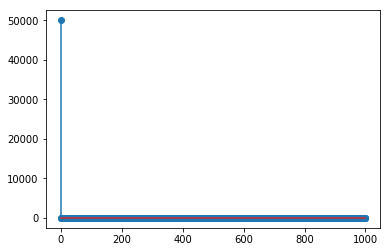

In [32]:
X = fftpack.fft(x)

print(X[0:5])
print(len(X))

plt.stem(X)

Aha! We are getting **complex** values! 

What we actually plot in the spectrum turns out to be the size of a complex number, its **modulus**, defined as:

$$Mod(a+bi) = \sqrt{a^2+b^2}$$

In python, we can work with complex numbers as follows:

In [28]:
c = complex(3,4) # syntax: complex(a,b) for defining a+bi
print(c)
print(c.real) # the real component, a
print(c.imag) # the imaginary component, b
print(np.abs(c)) # the modulus

(3+4j)
3.0
4.0
5.0


So let's try plotting the Fourier transform again, this time plotting the modulus.

[  5.00000000e+04   2.41111833e-14   1.60023274e-14   3.89470380e-14
   3.89034483e-14]


<Container object of 3 artists>

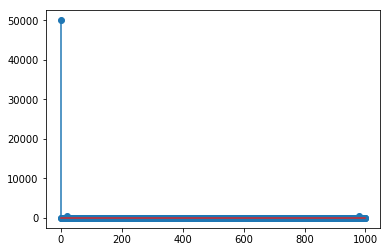

In [33]:
print(np.abs(X[0:5]))
plt.stem(np.abs(X))

But there are still some problems. First the x-axis is in terms of points. We have 1000 points, so we get an x-axis going up to 1000. How do we get this in terms of frequency? We need to set the x-axis to go from [$-f_{Nyquist}, f_{Nyquist}$], $\Delta f_s$ apart. This is where `fftpack.fftfreq` comes in. 

***Discussion: What do you notice about the array `freqs`? How long is it? What numbers does it range over? How far are the numbers apart?***


In [37]:
freqs = fftpack.fftfreq(len(x)) * fs
print(freqs)

#print(fftpack.fftfreq(len(x)))


[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9  15.   15.1  15.2  15.3  15.4  15.5
  15.6  15.7  15.8  15.9  16.   16.1  16.2  16.3  1

OK, now we're set!  

Text(0,0.5,'Fourier transform of signal')

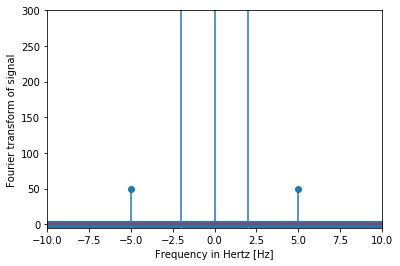

In [40]:
fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Magnitude')
#ax.set_xlim(-fs/2, fs/2)
ax.set_xlim(-10, 10)
ax.set_ylim(-5, 300)
ax.set_ylabel('Fourier transform of signal')


***In-class exercise: Fourier transform of a square wave. Compute a spectrum for the square wave you defined in the Review Questions.***

---

## From spectrum to spectrogram

Let's have some fun with [Japanese vowels](http://www.phonetics.ucla.edu/course/chapter9/japanese/japanese.html) from soundfiles collected by Peter Ladefoged. First we'll use `librosa` to load an audio recording of [ma]. And just for kicks, let's listen to it resampled at different sampling rates.

In [ ]:
y, sr = librosa.load("ma.aiff", sr = None)
print(type(y)) # Note that it is a numpy array
print("The sampling rate is: ", sr, "Hz")


y_8k = librosa.resample(y, sr, 8000)
y_2k = librosa.resample(y, sr, 2000)
y_500 = librosa.resample(y, sr, 500)

display(Audio(data=y,rate = sr))
display(Audio(data=y_8k,rate = 8000))
display(Audio(data=y_2k,rate = 2000))
display(Audio(data=y_500,rate = 500))


---
***In-class exercise: compute the spectrum of [a] in the recording.***

1. Plot the waveform, and use the waveform to determine what part of the recording has a steady-state [a]. 
2. Now that you've determined that, work with just that portion of the signal for computing the spectrum.
3. Try computing the spectrum for the [a] sampled at different sampling rates. How does this affect what you see in the resulting spectrum, if at all?
4. Do your computed spectra look as expected, given what you know about formants? You might try computing spectra for the other vowel samples at the webpage, too, e.g., [o], [i], etc.

---

Now let's work towards computing the spectrogram for the audio file. First let's plot the waveform of the audio file.

***Discussion: do you notice a technical problem with the recording revealed from plotting the waveform?***

In [ ]:
N = y.shape[0]
L = N / sr

print(f'Audio length: {L:.2f} seconds')

f, ax = plt.subplots()
ax.plot(np.arange(N) / sr, y)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

We can compute a spectrogram using [spectral analysis tools provided by `scipy.signal`](https://github.com/scipy/scipy/blob/master/scipy/signal/spectral.py), namely, `scipy.signal.spectrogram`.

In [ ]:
help(signal.spectrogram)

We can use the example code from the help file to try to compute the spectrogram for [ma].

***Discussion: Does the spectrogram look as you expect? Fiddle with the settings of the plot as suits you. Also try using the code from [Elegant SciPy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) used to produce figure 4-4. How does that look? Compare your computed spectrograms to the ones you get when you analyze the [ma] file in Praat.***

In [ ]:
f,t, Sxx = signal.spectrogram(y,sr)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

To better understand how scipy.signal.spectrogram works, let's look at how it is defined. We can do this [using the `inspect` module](https://stackoverflow.com/questions/427453/how-can-i-get-the-source-code-of-a-python-function#427533). We can also look at [the code on github](https://github.com/scipy/scipy/blob/master/scipy/signal/spectral.py), which is a little prettier.

In [ ]:
import inspect
lines = inspect.getsourcelines(signal.spectrogram)
print("".join(lines[0]))

Well that's not that helpful. Looks like we need to take a look at `signal._spectral_helper`, which we can look at in the github code.

In [ ]:
# This doesn't work!
#lines = inspect.getsourcelines(signal.spectral_helper)
#print("".join(lines[0]))

Now let's use the code from [Elegant Scipy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) used to produce Figure 4.3, which breaks down spectrogram computation step by step.

In [ ]:
from skimage import util

M = 1024

slices = util.view_as_windows(y, window_shape=(M,), step=100)
print(f'Audio shape: {y.shape}, Sliced audio shape: {slices.shape}')

win = np.hanning(M + 1)[:-1]
slices = slices * win

slices = slices.T
print('Shape of `slices`:', slices.shape)

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

In [ ]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, sr / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

## Working through DFT, FFT

Finally, let's work through the [Elegant Scipy](https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html) material on DFT and FFT together. This is the section that starts after Figure 4.4.